In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "static" / "data"

In [2]:
import geopandas

amazon = geopandas.read_file(DATA_DIRECTORY / "amazon_river" / "amazon_river.gpkg")

amazon.head()

,bbox_east,bbox_north,bbox_south,bbox_west,place_name,geometry
0,-49.10927,0.70653,-4.44219,-73.450126,"Rio Amazonas, Microrregião de Manaus, Mesorreg...","MULTILINESTRING ((1612358.589 9508606.173, 161..."


In [3]:
amazon.crs

<Derived Projected CRS: PROJCS["Mercator_2SP",GEOGCS["GCS_GRS 1980(IUGG, 1 ...>
Name: Mercator_2SP
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Mercator (variant B)
Datum: D_unknown
- Ellipsoid: GRS80
- Prime Meridian: Unknown

<AxesSubplot: >

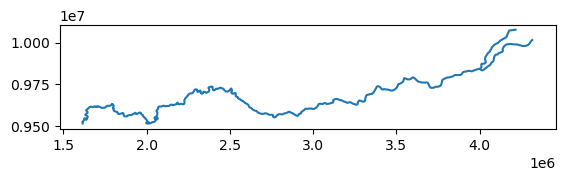

In [4]:
amazon.plot()

The LineString that is presented here is quite detailed, so let’s see how we can generalize them a bit. As we can see from the coordinate reference system, the data is projected in a system using Mercator projection based on SIRGAS datum, and metres as a unit.

Generalization can be done easily by using a Shapely function called .simplify(). The tolerance parameter can be used to adjusts how much geometries should be generalized. The tolerance value is tied to the coordinate system of the geometries. Hence, the value we pass here is 20 000 meters (20 kilometers).

<AxesSubplot: >

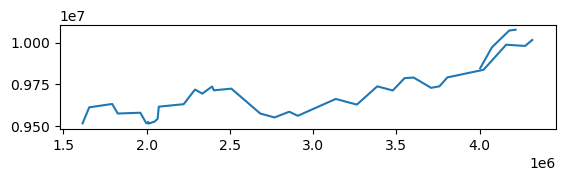

In [5]:
# Generalize geometry
amazon['simplegeom'] = amazon.simplify(tolerance=20000)

# Set geometry to be our new simlified geometry
amazon = amazon.set_geometry('simplegeom')

# Plot 
amazon.plot()

Reclassifying data based on specific criteria is a common task when doing GIS analysis. The purpose of this lesson is to see how we can reclassify values based on some criteria. We could, for example, classify information based on travel times and housing prices using these criteria:

if travel time to my work is less than 30 minutes, AND

the rent of the apartment is less than 1000 € per month

If both criteria are met: I go to see the appartment and try to rent it If not: I continue to look for something else

In this tutorial, we will:

Use classification schemes from the PySAL mapclassify library to classify travel times into multiple classes.

Create a custom classifier to classify travel times and distances in order to find out good locations to buy an apartment with these conditions:

good public transport accessibility to city center

bit further away from city center where the prices are presumably lower

In [6]:
accessibility_grid = geopandas.read_file(
    DATA_DIRECTORY
    / "helsinki_region_travel_times_to_railway_station"
    / "helsinki_region_travel_times_to_railway_station.gpkg"
)
accessibility_grid.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


There are plenty of different variables in the accessibility data set (see from here the description for all attributes) but what we are interested in are columns called pt_r_tt which is telling the time in minutes that it takes to reach city center from different parts of the city, and walk_d that tells the network distance by roads to reach city center from different parts of the city (almost equal to Euclidian distance).

The NoData values are presented with value -1. Thus we need to remove the No Data values first.

In [7]:
# Include only data that is above or equal to 0
accessibility_grid = accessibility_grid.loc[accessibility_grid["pt_r_tt"] >=0]

<AxesSubplot: >

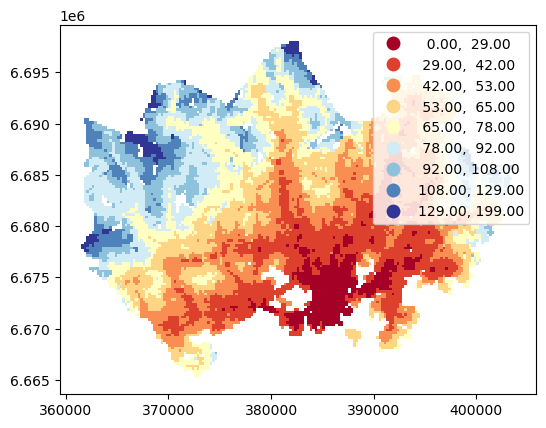

In [8]:
# Plot using 9 classes and classify the values using "Natural Breaks" classification
accessibility_grid.plot(column="pt_r_tt", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

<AxesSubplot: >

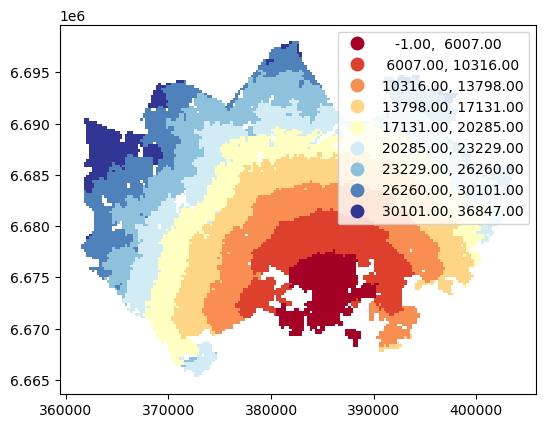

In [9]:
# Plot walking distance
accessibility_grid.plot(column="walk_d", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

<H3>Applying classifiers to data</H3>
As mentioned, the scheme option defines the classification scheme using pysal/mapclassify. Let’s have a closer look at how these classifiers work.

In [10]:
import mapclassify

In [11]:
mapclassify.NaturalBreaks(y=accessibility_grid["pt_r_tt"], k=9)

NaturalBreaks           

    Interval       Count
------------------------
[  0.00,  30.00] |   837
( 30.00,  43.00] |  2361
( 43.00,  54.00] |  2453
( 54.00,  66.00] |  2222
( 66.00,  77.00] |  1548
( 77.00,  89.00] |  1483
( 89.00, 103.00] |  1079
(103.00, 125.00] |   811
(125.00, 199.00] |   226

In [12]:
# Default is 5 quantiles
mapclassify.Quantiles(y=accessibility_grid["pt_r_tt"])

Quantiles               

    Interval       Count
------------------------
[  0.00,  41.00] |  2674
( 41.00,  52.00] |  2576
( 52.00,  66.00] |  2623
( 66.00,  85.00] |  2616
( 85.00, 199.00] |  2531

In [13]:
# Get thresholds as an array
classifier = mapclassify.NaturalBreaks(y=accessibility_grid["pt_r_tt"], k=9)
classifier.bins

array([ 29.,  42.,  54.,  66.,  77.,  89., 103., 125., 199.])

Let’s apply one of the Pysal classifiers into our data and classify the travel times by public transport into 9 classes The classifier needs to be initialized first with make() function that takes the number of desired classes as input parameter

In [14]:
# Create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=9)

In [15]:
# Classify the data
classifications = accessibility_grid[["pt_r_tt"]].apply(classifier)

# Let's see what we have
classifications.head()

,pt_r_tt
0,8
1,8
2,8
3,8
4,7


In [16]:
# Rename the column so that we know that it was classified with natural breaks
accessibility_grid["nb_pt_r_tt"] = accessibility_grid[["pt_r_tt"]].apply(classifier)

# Check the original values and classification
accessibility_grid[["pt_r_tt", "nb_pt_r_tt"]].head()

,pt_r_tt,nb_pt_r_tt
0,139,8
1,133,8
2,133,8
3,144,8
4,121,7


<AxesSubplot: >

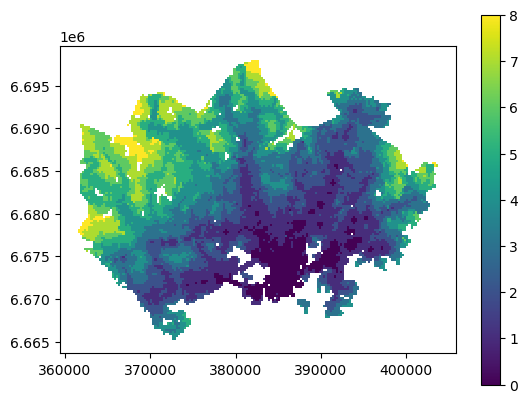

In [17]:
# Plot
accessibility_grid.plot(column="nb_pt_r_tt", linewidth=0, legend=True)

<AxesSubplot: ylabel='Frequency'>

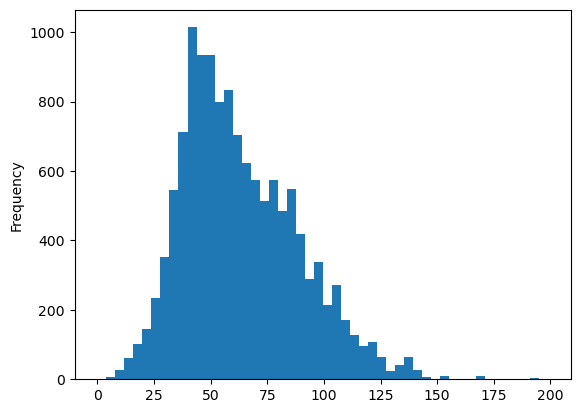

In [18]:
# Histogram for public transport rush hour travel time
accessibility_grid["pt_r_tt"].plot.hist(bins=50)

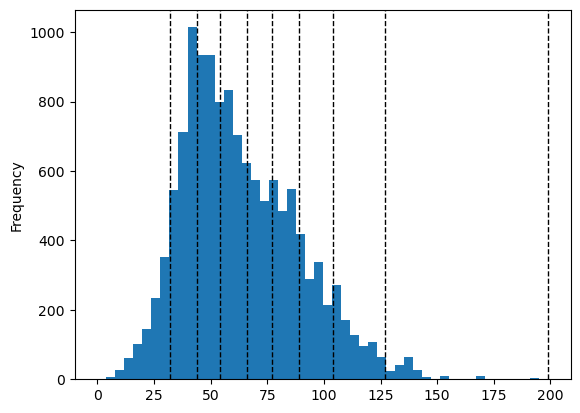

In [20]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.NaturalBreaks(y=accessibility_grid["pt_r_tt"], k=9)

# Plot histogram for public transport rush hour travel time
accessibility_grid["pt_r_tt"].plot.hist(bins=50)

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

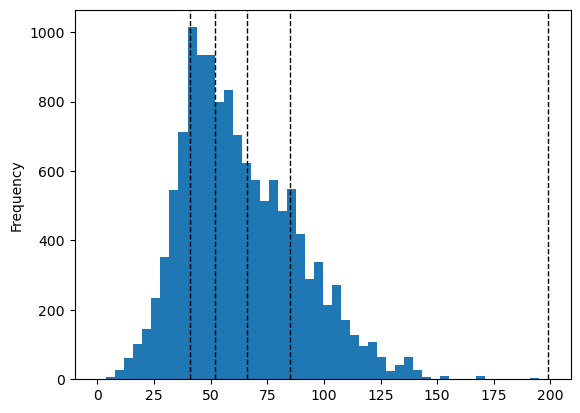

In [21]:
# Define classifier
classifier = mapclassify.Quantiles(y=accessibility_grid['pt_r_tt'])

# Plot histogram for public transport rush hour travel time
accessibility_grid["pt_r_tt"].plot.hist(bins=50)

for break_point in classifier.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

Let’s classify the geometries into two classes based on a given threshold -parameter. If the area of a polygon is lower than the threshold value (e.g., a certain distance), the output column will get a value 0, if it is larger, it will get a value 1. This kind of classification is often called a binary classification.

To classify each row of our GeoDataFrame we can iterate over each row or we can apply a function for each row. In our case, we will apply a lambda function for each row in our GeoDataFrame, which returns a value based on the conditions we provide.

Let’s do our classification based on two criteria: and find out grid cells

Grid cells where the travel time is lower or equal to 20 minutes

and they are further away than 4 km (4000 meters) from the city center.

In [22]:
# Let’s first see how to classify a single row:
accessibility_grid.iloc[0]["pt_r_tt"] < 20 and accessibility_grid.iloc[0]["walk_d"] > 4000

False

In [23]:
int(accessibility_grid.iloc[11293]["pt_r_tt"] < 20 and accessibility_grid.iloc[11293]["walk_d"] > 4000)

1

In [24]:
accessibility_grid["suitable_area"] = accessibility_grid.apply(lambda row: int(row["pt_r_tt"] < 20 and row["walk_d"] > 4000), axis=1)

In [25]:
accessibility_grid.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry,nb_pt_r_tt,suitable_area
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6...",8,0
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6...",8,0
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500.000 6697750.000, 382250.000 6...",8,0
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750.000 6697750.000, 382500.000 6...",8,0
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250.000 6697500.000, 381000.000 6...",7,0


In [26]:
# Get value counts
accessibility_grid["suitable_area"].value_counts()

0    13011
1        9
Name: suitable_area, dtype: int64

<AxesSubplot: >

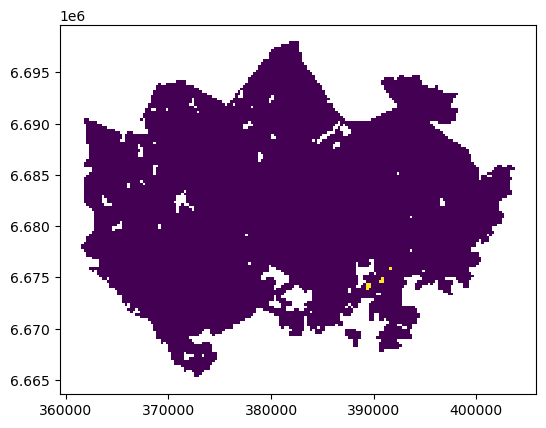

In [27]:
# Plot
accessibility_grid.plot(column="suitable_area", linewidth=0)